Domain Generalization via Gradient Surgery

Ufuk Altun

The Baseline Model

In [ ]:
using Pkg; 
pkg"add Knet IterTools MLDatasets FileIO Images CUDA"

In [1]:
ENV["COLUMNS"]=72
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using MLDatasets: MNIST
using FileIO: load, save
using CUDA: CUDA, CuArray # functional
using Knet: Knet, conv4, pool, mat, nll, accuracy, progress, sgd, param, param0, dropout, relu, minibatch, Data
using Knet, IterTools
using Images

In [2]:
xtrain1=load("xdata_cartoon.jld2")["data"];
ytrain1=load("ydata_cartoon.jld2")["data"];

xtrain2=load("xdata_photo.jld2")["data"];
ytrain2=load("ydata_photo.jld2")["data"];

xtrain3=load("xdata_sketch.jld2")["data"];
ytrain3=load("ydata_sketch.jld2")["data"];

xtest=load("xdata_art_painting.jld2")["data"];
ytest=load("ydata_art_painting.jld2")["data"];


In [3]:
@show size(xtrain1)
@show size(ytrain1)
@show size(xtrain2)
@show size(ytrain2)
@show size(xtrain3)
@show size(ytrain3)
@show size(xtest)
@show size(ytest)

size(xtrain1) = (227, 227, 3, 2344)
size(ytrain1) = (2344,)
size(xtrain2) = (227, 227, 3, 1670)
size(ytrain2) = (1670,)
size(xtrain3) = (227, 227, 3, 3929)
size(ytrain3) = (3929,)
size(xtest) = (227, 227, 3, 2048)
size(ytest) = (2048,)


(2048,)

In [4]:
dtrn1=Knet.minibatch(xtrain1[:,:,:,1:1000],ytrain1[1:1000],100,xtype=Array{Float32},ytype=Array{Int32});
dtrn2=Knet.minibatch(xtrain2[:,:,:,1:1000],ytrain2[1:1000],100,xtype=Array{Float32},ytype=Array{Int32});
dtrn3=Knet.minibatch(xtrain3[:,:,:,1:1000],ytrain3[1:1000],100,xtype=Array{Float32},ytype=Array{Int32});

dtrn_baseline=Knet.minibatch(cat(xtrain1[:,:,:,1:1000],xtrain2[:,:,:,1:1000],xtrain3[:,:,:,1:1000],dims=4), cat(ytrain1[1:1000],ytrain2[1:1000],ytrain3[1:1000],dims=1), 100, shuffle=true, xtype=Array{Float32},ytype=Array{Int32});

dtst=Knet.minibatch(xtest,ytest,100, xtype=Array{Float32},ytype=Array{Int32});

In [21]:
include("models.jl")
include("utils.jl")

trainresults (generic function with 1 method)

In [22]:
GS_model =   Chain(Conv(11, 11,   3,  96;pad_conv=0,stri_conv=4,pad_pool=0,stri_pool=2),
                         Conv( 5,  5,  96, 256;pad_conv=2,stri_conv=1,pad_pool=0,stri_pool=2),
                         Conv( 3,  3, 256, 384;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=1,wind=1),
                         Conv( 3,  3, 384, 384;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=1,wind=1),
                         Conv( 3,  3, 384, 256;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=3),
                    Dense(4*4*256, 4*4*256,identity,pdrop=0.5),
                    Dense(4*4*256, 7,identity,pdrop=0.5));

In [23]:
baseline_model =   Chain(Conv(11, 11,   3,  96;pad_conv=0,stri_conv=4,pad_pool=0,stri_pool=2),
                         Conv( 5,  5,  96, 256;pad_conv=2,stri_conv=1,pad_pool=0,stri_pool=2),
                         Conv( 3,  3, 256, 384;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=1,wind=1),
                         Conv( 3,  3, 384, 384;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=1,wind=1),
                         Conv( 3,  3, 384, 256;pad_conv=1,stri_conv=1,pad_pool=0,stri_pool=3),
                    Dense(4*4*256, 4*4*256,identity,pdrop=0.5),
                    Dense(4*4*256, 7,identity,pdrop=0.5));

In [24]:
GS = trainresultsGS("GS.jld2",GS_model);

Train from scratch? stdin> y


┣██                  ┫ [10.00%, 10/100, 05:53/58:47, 32.67s/i]  ┌ Warning: accuracy(model,data; o...) is deprecated, please use accuracy(model; data=data, o...)
└ @ Knet.Ops20 /Users/ufukaltun/.julia/packages/Knet/59nH1/src/ops20/loss.jl:205
┣████████████████████┫ [100.00%, 100/100, 01:54:10/01:54:10, 68.50s/i] 


Float32[NaN; NaN; 0.55; 0.8105]


In [39]:
baseline = trainresults("baseline.jld2",baseline_model);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 300/300, 02:43:36/02:43:36, 32.72s/i]  


Float32[1.3590528; 2.4063256; 0.55; 0.8105]


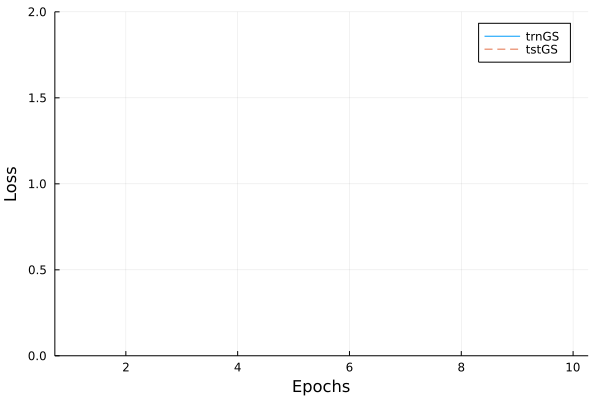

In [25]:
using Plots; default(fmt=:png,ls=:auto)

plot([GS[1,:], GS[2,:]],ylim=(0.0,2),
     labels=["trnGS" "tstGS"],xlabel="Epochs",ylabel="Loss")

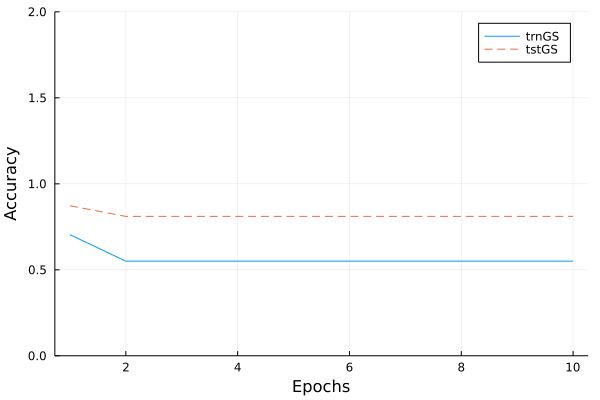

In [38]:
plot(  [GS[3,:] , GS[4,:] ],ylim=(0.0,2),
     labels=["trnGS" "tstGS"],xlabel="Epochs",ylabel="Accuracy")

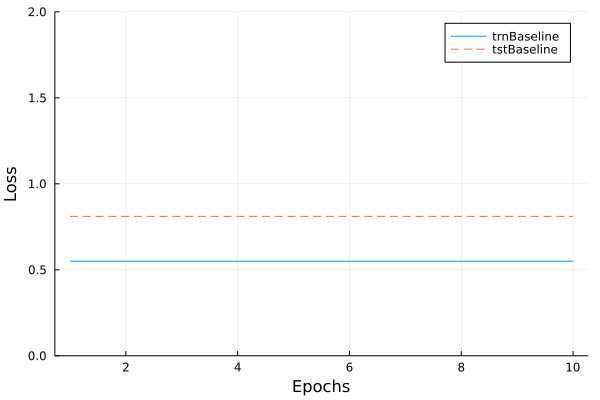

In [41]:
plot([baseline[3,:], baseline[4,:]],ylim=(0.0,2),
     labels=["trnBaseline" "tstBaseline"],xlabel="Epochs",ylabel="Loss")

In [44]:
accuracy(baseline_model,data=dtst)

0.1895

Deneme

In [ ]:
progress!(sgdGS(GS_model, ncycle(dtrn1,10), ncycle(dtrn2,10), ncycle(dtrn3,10) ))

param1 = P(Array{Float32, 4}(11,11,3,96))
param1 = P(Array{Float32, 4}(1,1,96,1))
param1 = P(Array{Float32, 4}(5,5,96,256))
param1 = P(Array{Float32, 4}(1,1,256,1))
param1 = P(Array{Float32, 4}(3,3,256,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,256))
param1 = P(Array{Float32, 4}(1,1,256,1))
param1 = P(Matrix{Float32}(4096,4096))
param1 = 

┣▏                   ┫ [1.00%, 1/100, 01:02/01:42:47, 61.67s/i] 

P(Vector{Float32}(4096))
param1 = P(Matrix{Float32}(7,4096))
param1 = P(Vector{Float32}(7))
param1 = P(Array{Float32, 4}(11,11,3,96))
param1 = P(Array{Float32, 4}(1,1,96,1))
param1 = P(Array{Float32, 4}(5,5,96,256))
param1 = P(Array{Float32, 4}(1,1,256,1))
param1 = P(Array{Float32, 4}(3,3,256,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,256))
param1 = P(Array{Float32, 4}(1,1,256,1))


┣▍                   ┫ [2.00%, 2/100, 01:35/01:19:03, 33.19s/i] 

param1 = P(Matrix{Float32}(4096,4096))
param1 = P(Vector{Float32}(4096))
param1 = P(Matrix{Float32}(7,4096))
param1 = P(Vector{Float32}(7))
param1 = P(Array{Float32, 4}(11,11,3,96))
param1 = P(Array{Float32, 4}(1,1,96,1))
param1 = P(Array{Float32, 4}(5,5,96,256))
param1 = P(Array{Float32, 4}(1,1,256,1))
param1 = P(Array{Float32, 4}(3,3,256,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,384))
param1 = P(Array{Float32, 4}(1,1,384,1))
param1 = P(Array{Float32, 4}(3,3,384,256))
param1 = P(Array{Float32, 4}(1,1,256,1))


┣▌                   ┫ [3.00%, 3/100, 02:07/01:10:45, 32.49s/i] 

param1 = P(Matrix{Float32}(4096,4096))
param1 = P(Vector{Float32}(4096))
param1 = P(Matrix{Float32}(7,4096))
param1 = P(Vector{Float32}(7))


In [38]:
@doc @diff

Usage:

```
x = Param([1,2,3])          # The user declares parameters with `Param`
y = @diff sum(x .* x)       # computes gradients using `@diff`
grad(y,x) => [2,4,6]        # looks up the gradient of a parameter with `grad`
```

`Param(x)` returns a struct that acts like `x` but marks it as a parameter you want to compute gradients with respect to.

`@diff expr` evaluates an expression and returns a struct that contains its value (which should be a scalar) and gradients with respect to the `Param`s used in the computation.

`grad(y, x)` returns the gradient of a `@diff` result `y` with respect to any parameter `x::Param`. (`nothing` may be returned if the gradient is 0).

`value(x)` returns the value associated with `x` if `x` is a `Param` or the output of `@diff`, otherwise returns `x`.

`params(x)` returns an iterator of `Param`s found by a recursive search of object `x`, which is typically a model or a `@diff` result.

Alternative usage:

```
x = [1 2 3]
f(x) = sum(x .* x)
f(x) => 14
grad(f)(x) => [2 4 6]
gradloss(f)(x) => ([2 4 6], 14)
```

Given a scalar valued function `f`, `grad(f,argnum=1)` returns another function `g` which takes the same inputs as `f` and returns the gradient of the output with respect to the argnum'th argument. `gradloss` is similar except the resulting function also returns f's output.


In [11]:
accuracy(Source1_model,data=dtrn1)

0.170625

In [47]:
@show (data=dtst)

data = dtst = 2-element Data{Tuple{Array{Float32, N} where N, Array{Int32, N} where N}}


2-element Data{Tuple{Array{Float32, N} where N, Array{Int32, N} where N}}

In [ ]:
accuracy(baseline_model,data=dtst)

In [38]:
baseline = trainresults("baseline.jld2",baseline_model);

Train from scratch? stdin> y


┣▏                   ┫ [1.00%, 8/800, 01:29/02:29:00, 10.30s/i] ┌ Warning: accuracy(model,data; o...) is deprecated, please use accuracy(model; data=data, o...)
└ @ Knet.Ops20 /Users/ufukaltun/.julia/packages/Knet/59nH1/src/ops20/loss.jl:205
┣█▌                  ┫ [8.00%, 64/800, 19:18/04:01:15, 10.69s/i] 

LoadError: InterruptException:

In [75]:
accuracy(baseline_model,data=dtrn)

0.14375

In [39]:
@doc sgd

```
minimize(func, data, optimizer=Adam(); params)
sgd     (func, data; lr=0.1,  gclip, params)
momentum(func, data; lr=0.05, gamma=0.95, gclip, params)
nesterov(func, data; lr=0.05, gamma=0.95, gclip, params)
adagrad (func, data; lr=0.05, eps=1e-6, gclip, params)
rmsprop (func, data; lr=0.01, rho=0.9, eps=1e-6, gclip, params)
adadelta(func, data; lr=1.0,  rho=0.9, eps=1e-6, gclip, params)
adam    (func, data; lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, gclip, params)
```

Return an iterator which applies `func` to arguments in `data`, i.e.  `(func(args...) for args in data)`, and updates the parameters every iteration to minimize `func`.  `func` should return a scalar value.

The common keyword argument `params` can be used to list the `Param`s to be optimized.  If not specified, any `Param` that takes part in the computation of `func(args...)` will be updated.

The common keyword argument `gclip` can be used to implement per-parameter gradient clipping. For a parameter gradient `g`, if `norm(g) > gclip > 0`, `g` is scaled so that its norm is equal to `gclip`. If not specified no gradient clipping is performed.

These functions do not perform optimization, but return an iterator that can. Any function that produces values from an iterator can be used with such an object, e.g. `progress!(sgd(f,d))` iterates the sgd optimizer and displays a progress bar. For convenience, appending `!` to the name of the function iterates and returns `nothing`, i.e. `sgd!(...)` is equivalent to `(for x in sgd(...) end)`.

We define optimizers as lazy iterators to have explicit control over them:

  * To report progress use `progress(sgd(f,d))`.
  * To run until convergence use `converge(sgd(f,cycle(d)))`.
  * To run multiple epochs use `sgd(f,repeat(d,n))`.
  * To run a given number of iterations use `sgd(f,take(cycle(d),n))`.
  * To do a task every n iterations use `(task() for (i,j) in enumerate(sgd(f,d)) if i%n == 1)`.

These functions apply the same algorithm with the same configuration to every parameter by default. `minimize` takes an explicit optimizer argument, all others call `minimize` with an appropriate optimizer argument (see `@doc update!` for a list of possible optimizers). Before calling [`update!`](@ref) on a `Param`, `minimize` sets its `opt` field to a copy of this default optimizer if it is not already set. The `opt` field is used by the `update!` function to determine the type of update performed on that parameter.  If you need finer grained control, you can set the optimizer of an individual `Param` by setting its `opt` field before calling one of these functions. They will not override the `opt` field if it is already set, e.g. `sgd(model,data)` will perform an `Adam` update for a parameter whose `opt` field is an `Adam` object. This also means you can stop and start the training without losing optimization state, the first call will set the `opt` fields and the subsequent calls will not override them.

Given a parameter `w` and its gradient `g` here are the updates applied by each optimizer:

```
# sgd (http://en.wikipedia.org/wiki/Stochastic_gradient_descent)
w .= w - lr * g

# momentum (http://jlmelville.github.io/mize/nesterov.html)
v .= gamma * v - lr * g
w .= w + v

# nesterov (http://jlmelville.github.io/mize/nesterov.html)
w .= w - gamma * v
v .= gamma * v - lr * g
w .= w + (1 + gamma) * v

# adagrad (http://www.jmlr.org/papers/v12/duchi11a.html)
G .= G + g .^ 2
w .= w - lr * g ./ sqrt(G + eps)

# rmsprop (http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
G .= rho * G + (1-rho) * g .^ 2 
w .= w - lr * g ./ sqrt(G + eps)

# adadelta (http://arxiv.org/abs/1212.5701)
G .= rho * G + (1-rho) * g .^ 2
update = sqrt(delta + eps) .* g ./ sqrt(G + eps)
w = w - lr * update
delta = rho * delta + (1-rho) * update .^ 2

# adam (http://arxiv.org/abs/1412.6980)
v = beta1 * v + (1 - beta1) * g
G = beta2 * G + (1 - beta2) * g .^ 2
vhat = v ./ (1 - beta1 ^ t)
Ghat = G ./ (1 - beta2 ^ t)
w = w - (lr / (sqrt(Ghat) + eps)) * vhat
```


In [40]:
@doc update!

```
update!(weights::Param, gradients)
update!(weights, gradients; lr=0.1, gclip=0)
update!(weights, gradients, optimizers)
```

Update the `weights` using their `gradients` and the optimization algorithms specified using (1) the `opt` field of a `Param`, (2) keyword arguments, (3) the third argument.

`weights` can be an individual `Param`, numeric array, or a collection of arrays/Params represented by an iterator or dictionary. `gradients` should be a matching individual array or collection. In the first form, the optimizer should be specified in `weights.opt`. In the second form the optimizer defaults to [`SGD`](@ref) with learning rate `lr` and gradient clip `gclip`. In the third form `optimizers` should be a matching individual optimizer or collection of optimizers.  The `weights` and possibly `gradients` and `optimizers` are modified in-place.

Individual optimization parameters can be one of the following types. The keyword arguments for each constructor and their default values are listed as well.

  * [`SGD`](@ref)`(;lr=0.1, gclip=0)`
  * [`Momentum`](@ref)`(;lr=0.05, gamma=0.95, gclip=0)`
  * [`Nesterov`](@ref)`(;lr=0.05, gamma=0.95, gclip=0)`
  * [`Adagrad`](@ref)`(;lr=0.05, eps=1e-6, gclip=0)`
  * [`Rmsprop`](@ref)`(;lr=0.01, rho=0.9, eps=1e-6, gclip=0)`
  * [`Adadelta`](@ref)`(;lr=1.0, rho=0.9, eps=1e-6, gclip=0)`
  * [`Adam`](@ref)`(;lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, gclip=0)`

# Example:

```
w = Param(rand(d), Adam())  # a Param with a specified optimizer
g = lossgradient0(w)        # gradient g has the same shape as w
update!(w, g)               # update w in-place with Adam()

w = rand(d)                 # an individual weight array
g = lossgradient1(w)        # gradient g has the same shape as w
update!(w, g)               # update w in-place with SGD()
update!(w, g; lr=0.1)       # update w in-place with SGD(lr=0.1)
update!(w, g, SGD(lr=0.1))  # update w in-place with SGD(lr=0.1)

w = (rand(d1), rand(d2))    # a tuple of weight arrays
g = lossgradient2(w)        # g will also be a tuple
p = (Adam(), SGD())         # p has optimizers for each w[i]
update!(w, g, p)            # update each w[i] in-place with g[i],p[i]

w = Any[rand(d1), rand(d2)] # any iterator can be used
g = lossgradient3(w)        # g will be similar to w
p = Any[Adam(), SGD()]      # p should be an iterator of same length
update!(w, g, p)            # update each w[i] in-place with g[i],p[i]

w = Dict(:a => rand(d1), :b => rand(d2)) # dictionaries can be used
g = lossgradient4(w)
p = Dict(:a => Adam(), :b => SGD())
update!(w, g, p)
```


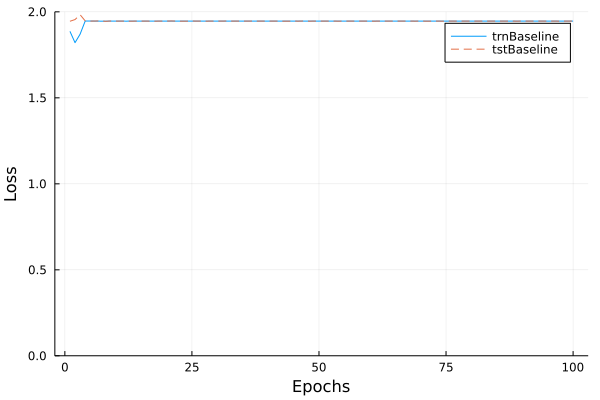

In [71]:
using Plots; default(fmt=:png,ls=:auto)

# Comparison to MLP shows faster convergence, better generalization
plot([baseline[1,:], baseline[2,:]],ylim=(0.0,2),
     labels=["trnBaseline" "tstBaseline"],xlabel="Epochs",ylabel="Loss")